In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
!mkdir -p ./model/vqgan_imagenet_f16_1024/checkpoints
!wget 'https://heibox.uni-heidelberg.de/d/8088892a516d4e3baf92/files/?p=%2Fckpts%2Flast.ckpt&dl=1' -O './model/vqgan_imagenet_f16_1024/checkpoints/last.ckpt'
!mkdir -p ./model/vqgan_imagenet_f16_1024/configs
!wget 'https://heibox.uni-heidelberg.de/d/8088892a516d4e3baf92/files/?p=%2Fconfigs%2Fmodel.yaml&dl=1' -O './model/vqgan_imagenet_f16_1024/configs/model.yaml'

--2022-03-31 21:43:19--  https://heibox.uni-heidelberg.de/d/8088892a516d4e3baf92/files/?p=%2Fckpts%2Flast.ckpt&dl=1
Resolving heibox.uni-heidelberg.de (heibox.uni-heidelberg.de)... 129.206.7.113
Connecting to heibox.uni-heidelberg.de (heibox.uni-heidelberg.de)|129.206.7.113|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://heibox.uni-heidelberg.de/seafhttp/files/f05086bc-bf42-4156-a6c2-2863005f0b25/last.ckpt [following]
--2022-03-31 21:43:20--  https://heibox.uni-heidelberg.de/seafhttp/files/f05086bc-bf42-4156-a6c2-2863005f0b25/last.ckpt
Reusing existing connection to heibox.uni-heidelberg.de:443.
HTTP request sent, awaiting response... 200 OK
Length: 957954257 (914M) [application/octet-stream]
Saving to: ‘./model/vqgan_imagenet_f16_1024/checkpoints/last.ckpt’

./model/vqgan_image 100%[===================>] 913.58M  14.9MB/s    in 61s     

2022-03-31 21:44:21 (15.0 MB/s) - ‘./model/vqgan_imagenet_f16_1024/checkpoints/last.ckpt’ saved [957954257/957

In [4]:
!git clone https://github.com/YES-ai/taming-transformers.git

Cloning into 'taming-transformers'...
remote: Enumerating objects: 1344, done.
remote: Counting objects: 100% (534/534), done.
remote: Compressing objects: 100% (499/499), done.
remote: Total 1344 (delta 60), reused 488 (delta 31), pack-reused 810
Receiving objects: 100% (1344/1344), 412.89 MiB | 47.12 MiB/s, done.
Resolving deltas: 100% (269/269), done.


In [5]:
!git clone https://github.com/YES-ai/MaskGIT-pytorch.git

Cloning into 'MaskGIT-pytorch'...
remote: Enumerating objects: 51, done.
remote: Counting objects: 100% (51/51), done.
remote: Compressing objects: 100% (51/51), done.
remote: Total 51 (delta 23), reused 4 (delta 0), pack-reused 0
Unpacking objects: 100% (51/51), done.


In [2]:
!pip install omegaconf>=2.0.0 pytorch-lightning>=1.0.8 einops transformers torchsummary

In [3]:
import io
import numpy as np
import matplotlib.pyplot as plt
from omegaconf import OmegaConf
import os, sys
import PIL
from PIL import Image
from PIL import ImageDraw, ImageFont
import requests
import torch
import torch.nn.functional as F
from torchsummary import summary
import torchvision.transforms as T
import torchvision.transforms.functional as TF
import yaml
import torch
import torch.nn as nn
import torch.nn.functional as F

DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [4]:
import sys
sys.path.append("./taming-transformers")
sys.path.append("./MaskGIT-pytorch")

In [5]:
from omegaconf import OmegaConf
config_path = './model/vqgan_imagenet_f16_1024/configs/model.yaml'
config = OmegaConf.load(config_path)
import yaml
print(yaml.dump(OmegaConf.to_container(config)))

model:
  base_learning_rate: 4.5e-06
  params:
    ddconfig:
      attn_resolutions:
      - 16
      ch: 128
      ch_mult:
      - 1
      - 1
      - 2
      - 2
      - 4
      double_z: false
      dropout: 0.0
      in_channels: 3
      num_res_blocks: 2
      out_ch: 3
      resolution: 256
      z_channels: 256
    embed_dim: 256
    lossconfig:
      params:
        codebook_weight: 1.0
        disc_conditional: false
        disc_in_channels: 3
        disc_start: 0
        disc_weight: 0.8
      target: taming.modules.losses.vqperceptual.VQLPIPSWithDiscriminator
    n_embed: 1024
  target: taming.models.vqgan.VQModel



In [6]:
from taming.models.vqgan import VQModel
vqgan = VQModel(**config.model.params)

Working with z of shape (1, 256, 16, 16) = 65536 dimensions.
loaded pretrained LPIPS loss from taming/modules/autoencoder/lpips/vgg.pth
VQLPIPSWithDiscriminator running with hinge loss.


In [7]:
ckpt_path = './model/vqgan_imagenet_f16_1024/checkpoints/last.ckpt'
sd = torch.load(ckpt_path, map_location="cpu")["state_dict"]
missing, unexpected = vqgan.load_state_dict(sd, strict=False)

In [8]:
vqgan.cuda().eval()
torch.set_grad_enabled(False)

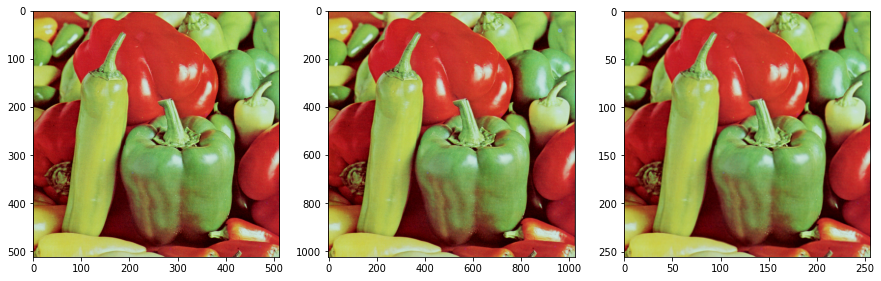

In [65]:
img = Image.open("./hr.png")
img_x, img_y = img.size
upsampled = img.resize((img_x * 2, img_y * 2))
downsampled = img.resize((img_x // 2, img_y // 2))

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15,5))
ax1.imshow(img)
ax2.imshow(upsampled)
ax3.imshow(downsampled)

In [11]:
def preprocess(img, target_image_size=256):
    s = min(img.size)
    
    if s < target_image_size:
        raise ValueError(f'min dim for image {s} < {target_image_size}')
        
    r = target_image_size / s
    s = (round(r * img.size[1]), round(r * img.size[0]))
    img = TF.resize(img, s, interpolation=PIL.Image.LANCZOS)
    img = TF.center_crop(img, output_size=2 * [target_image_size])
    img = torch.unsqueeze(T.ToTensor()(img), 0)
    return img

def download_image(url):
    resp = requests.get(url)
    resp.raise_for_status()
    image = PIL.Image.open(io.BytesIO(resp.content))
    return image

def downsample(img, factor=2):
  h, w = img.shape
  downsampled = TF.resize(img.unsqueeze(dim=0), [h // factor, w // factor], T.InterpolationMode.NEAREST)
  return downsampled.squeeze(dim=0)

def upsample(x, factor=2):
  h, w = x.shape
  upsampled = TF.resize(x.unsqueeze(dim=0), [h * factor, w * factor], T.InterpolationMode.NEAREST)
  return upsampled.squeeze(dim=0)

def read_image(path):
    image = PIL.Image.open(path)
    return image

def reconstruct_with_vqgan(x, model):
  # could also use model(x) for reconstruction but use explicit encoding and decoding here
  z, _, [_, _, indices] = model.encode(x)
  print(f"VQGAN --- {model.__class__.__name__}: latent shape: {z.shape[2:]}")
  xrec = model.decode(z)
  return xrec

def custom_to_pil(x):
  x = x.detach().cpu()
  x = torch.clamp(x, -1., 1.)
  x = (x + 1.)/2.
  x = x.permute(1,2,0).numpy()
  x = (255*x).astype(np.uint8)
  x = Image.fromarray(x)
  if not x.mode == "RGB":
    x = x.convert("RGB")
  return x

def preprocess_vqgan(x):
  x = 2.*x - 1.
  return x

In [12]:
quant_z, _, [_, _, indices] = vqgan.encode(preprocess(img).to(DEVICE))

/usr/local/lib/python3.7/dist-packages/torchvision/transforms/functional.py:405: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  "Argument interpolation should be of type InterpolationMode instead of int. "


In [17]:
indices

tensor([ 713,  297,  720,  245,  892,  618,  192,  577,  666,  635,  452,  362,
         460,  720,  328,  875,  918,  193,  339,  354,  700,  964,  783,  705,
         787,  148,  957,  453,  914,  323,  193,  541,  609,  737,  628,  810,
         897,  618,  897,  481,  323,  453,  345,   32,  176,  773,  269,   94,
         897,  682,  541,  764,  132,  225,  706,  916,  695,  872,  345,  720,
         329,  925,   94,  109,  869,  737,  628,  751,  315,  225,  706,  371,
         678,  742,  553,  447, 1006,  653,  489,  875,  176,  773,   66,  515,
         656,  579,  129,  706,  147,  437,  447,  669,  166,  515,  628,  269,
          56,  868,  810,  598,  528,  225,  560,  929,  297,  720,  553,  447,
         714,  653,  916,  810,  539,  810,   40,  202,  872,  713,  493,  257,
         906,  406,   56,  562,  849,  541,  614,  425,   12,  988,  294,  830,
         819,  789,  129,  663,  892,  653,  574,  611,  725,  389,  425,  528,
         147,  666,  402,  638,  400,  5

In [22]:
indices.view(quant_z.shape[0], -1)

tensor([[ 713,  297,  720,  245,  892,  618,  192,  577,  666,  635,  452,  362,
          460,  720,  328,  875,  918,  193,  339,  354,  700,  964,  783,  705,
          787,  148,  957,  453,  914,  323,  193,  541,  609,  737,  628,  810,
          897,  618,  897,  481,  323,  453,  345,   32,  176,  773,  269,   94,
          897,  682,  541,  764,  132,  225,  706,  916,  695,  872,  345,  720,
          329,  925,   94,  109,  869,  737,  628,  751,  315,  225,  706,  371,
          678,  742,  553,  447, 1006,  653,  489,  875,  176,  773,   66,  515,
          656,  579,  129,  706,  147,  437,  447,  669,  166,  515,  628,  269,
           56,  868,  810,  598,  528,  225,  560,  929,  297,  720,  553,  447,
          714,  653,  916,  810,  539,  810,   40,  202,  872,  713,  493,  257,
          906,  406,   56,  562,  849,  541,  614,  425,   12,  988,  294,  830,
          819,  789,  129,  663,  892,  653,  574,  611,  725,  389,  425,  528,
          147,  666,  402,  

In [100]:
from bidirectional_transformer import Encoder

class Transformer(nn.Module):
    def __init__(self, N=24, dim=768, codebook_size=1024):
        super(Transformer, self).__init__()
        self.tok_emb = nn.Embedding(codebook_size, dim)
        self.pos_emb = nn.Parameter(torch.zeros(1, 1024, dim))
        self.EncoderLayers = nn.ModuleList([Encoder(dim) for _ in range(N)])
        self.Token_Prediction = nn.Linear(in_features=dim, out_features=codebook_size)

    def forward(self, x):
        token_embeddings = self.tok_emb(x)
        t = token_embeddings.shape[1]
        position_embeddings = self.pos_emb[:, :t, :]
        embed = token_embeddings + position_embeddings
        for enc_layer in self.EncoderLayers:
            embed = enc_layer(embed)
        tkn_prd = self.Token_Prediction(embed)
        return tkn_prd


def top_k_logits(logits, k):
  v, ix = torch.topk(logits, k)
  out = logits.clone()
  out[out < v[..., [-1]]] = 0
  return out

def sr_mask(x):
  h, w = x.shape
  mask = torch.ones(h, w)
  even_h = np.arange(h, step=2) + 1
  even_w = np.arange(w, step=2) + 1
  mask[even_h, :] = 0
  mask[:, even_w] = 0
  return mask

def downsample_img(img, factor=2):
  _, h, w = img.shape
  return TF.resize(img, [h // factor, w // factor], T.InterpolationMode.NEAREST)

class SRMaskGIT(nn.Module):
  def __init__(self, vqgan, device):
    super(SRMaskGIT, self).__init__()
    self.vqgan = vqgan
    # self.transformer = BidirectionalTransformer(codebook_size=vqgan.quantize.n_e).to(device)
    self.transformer = Transformer(codebook_size=vqgan.quantize.n_e).to(device)
    self.device = device

  @torch.no_grad()
  def encode_to_z(self, x):
    quant_z, _, [_, _, indices] = self.vqgan.encode(x)
    indices = indices.view(quant_z.shape[0], -1)
    return quant_z, indices

  def forward(self, x):
    _, c, h, w = x.shape
    indices_h, indices_w = h // 16, w // 16 # hardcode for now, we should get this from VQGAN encoder
    _, z_indices = self.encode_to_z(x)
    # print(f"z_indices={z_indices.shape}")
    upsampled = self.upsample(z_indices, indices_h, indices_w).to(self.device)
    # print(f"upsampled={upsampled.shape}")
    mask = self.sr_mask(upsampled).to(self.device)
    # print(f"mask={mask.shape}")
    masked_input = (mask * upsampled).type(torch.int).flatten(1)
    # print(f"masked_input={masked_input.shape}")
    logits = self.transformer(masked_input)
    # print(f"logits={logits.shape}")
    return logits

  def masked_upsample_z(self, x):
    _, c, h, w = x.shape
    indices_h, indices_w = h // 16, w // 16 # hardcode for now, we should get this from VQGAN encoder
    _, z_indices = self.encode_to_z(x)
    # print(f"z_indices={z_indices.shape}")
    upsampled = self.upsample(z_indices, indices_h, indices_w).to(self.device)
    # print(f"upsampled={upsampled.shape}")
    mask = self.sr_mask(upsampled).to(self.device)
    # print(f"mask={mask.shape}")
    masked_input = (mask * upsampled).type(torch.int).flatten(1)
    return masked_input

  def upsample(self, z_indices, h, w, factor=2):
    bat_size, _ = z_indices.shape
    upsampled = TF.resize(z_indices.reshape(bat_size, h, w), [h * factor, w * factor], T.InterpolationMode.NEAREST)
    return upsampled

  def sr_mask(self, upsampled_indices, step=2):
    _, h, w = upsampled_indices.shape
    mask = torch.ones(h, w)
    even_h = np.arange(h, step=step) + 1
    even_w = np.arange(w, step=step) + 1
    mask[even_h, :] = 0
    mask[:, even_w] = 0
    return mask

  def gamma(self, name='cosine'):
    if name == "linear":
      return lambda r: 1 - r
    elif name == "cosine":
      return lambda r: np.cos(r * np.pi / 2)
    elif name == "square":
      return lambda r: 1 - r ** 2
    elif name == "cubic":
      return lambda r: 1 - r ** 3
    else:
      raise NotImplementedError

  @torch.no_grad()
  def sample(self, condition, batch_size=1, T=10, temp=1.0, gamma_mode='linear', N=256):
    indices = condition
    gamma_func = self.gamma(gamma_mode)

    for t in range(T + 1):
      unmasked = torch.clamp(indices, 0, 1).type(torch.int)
      n = np.ceil(gamma_func((t + 1)/T) * N)
      logits = self.transformer(indices)
      logits = logits / temp
      probs = F.softmax(logits, dim=-1)

      # flatten the first two dimension, i.e, H & W
      h, w, c = probs.shape
      probs = probs.reshape(h * w, c)
      sample_indices = torch.multinomial(probs, num_samples=1)
      probs_indices = torch.gather(probs, 1, sample_indices).reshape(h, w)
      probs_indices = torch.where(unmasked == 1, torch.ones_like(unmasked, dtype=torch.float), probs_indices)
      mask = torch.ceil(top_k_logits(probs_indices, int(N - n))).type(torch.int)

      sample_indices = sample_indices.reshape(h, w)
      new_indices = (sample_indices * mask).type(indices.dtype)
      indices = torch.where(unmasked == 1, indices, new_indices)

    return indices

In [66]:
hr_image = preprocess(img, target_image_size=512)

/usr/local/lib/python3.7/dist-packages/torchvision/transforms/functional.py:405: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  "Argument interpolation should be of type InterpolationMode instead of int. "


In [67]:
hr_image.shape

torch.Size([1, 3, 512, 512])

In [70]:
lr_image = preprocess(img, target_image_size=256)

/usr/local/lib/python3.7/dist-packages/torchvision/transforms/functional.py:405: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  "Argument interpolation should be of type InterpolationMode instead of int. "


In [71]:
lr_image.shape

torch.Size([1, 3, 256, 256])

In [101]:
sr_model = SRMaskGIT(vqgan, DEVICE).to(DEVICE)

In [102]:
masked_input = sr_model.masked_upsample_z(lr_image.to(DEVICE))

In [104]:
sampled = sr_model.sample(masked_input)

In [ ]:
def train_transformer(sr_model, train_loader, optimizer, criterion, scheduler, epochs=200):
  for epoch in range(epochs):
    for batch_idx, batch in enumerate(train_loader):
      hr = batch
      # use latent representation of the hi-res image as target
      z_true = sr_model.encode_to_z(hr)
      optimizer.zero_grad()
      lr = downsample_img(hr)
      z_pred = sr_model(lr)
      loss = criterion(z_pred, z_true)
      loss.backward()
      optimizer.step()
    scheduler.step()